## Libraries and constants

In [3]:
# Load project functions
import crypto_monetary_base as cmb

In [4]:
import pandas as pd
import datetime, math
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set()
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.labelpad'] = 10
mpl.rc('text', usetex=True)
plt.style.use('ggplot')

from IPython.display import display

In [5]:
%load_ext version_information
%version_information pandas, matplotlib, seaborn

Software versions
Python 3.8.6 64bit [GCC 10.2.1 20210110]
IPython 7.19.0
OS Linux 5.10.0 2 amd64 x86_64 with glibc2.29
pandas 1.2.0
matplotlib 3.3.3
seaborn 0.11.1
Sat Feb 13 20:45:24 2021 EST

## Starting simple

Let's start with what Bitcoin did: halving every ~4 years, 99+% of issuance within 30 years, 21M coins total. Bitcoin supply doesn't fully taper off until 2140 but it flattens out by about 2040. Let's analyze it from genesis through the next 30 years, to about 2050.

In [22]:
def btc_block_supply_curve():
    out = [
        # Block num,
        # Total supply,
    ]
    inflation_change_blocks = 210_000
    inflation_change_frac = 0.5
    y = 0
    block = 0
    while block < 2_200_000:
#     while True:
        block += 1
        num_changes = int(
            (block - 1) / inflation_change_blocks
        )
#         # Only consider the first 9 (of 32) halvenings
#         if num_changes > 9:
#             break
        block_reward = 50 * (
            inflation_change_frac ** num_changes
        )
        y += block_reward
        out.append([block, y])

    return out

In [23]:
start_date = datetime.date(2009, 1, 3)
block_time = datetime.timedelta(seconds=60 * 10)

block_supply = btc_block_supply_curve()

supply = cmb.datetime_supply_curve(
    start_date=start_date,
    block_time=block_time,
    block_supply=block_supply,
)

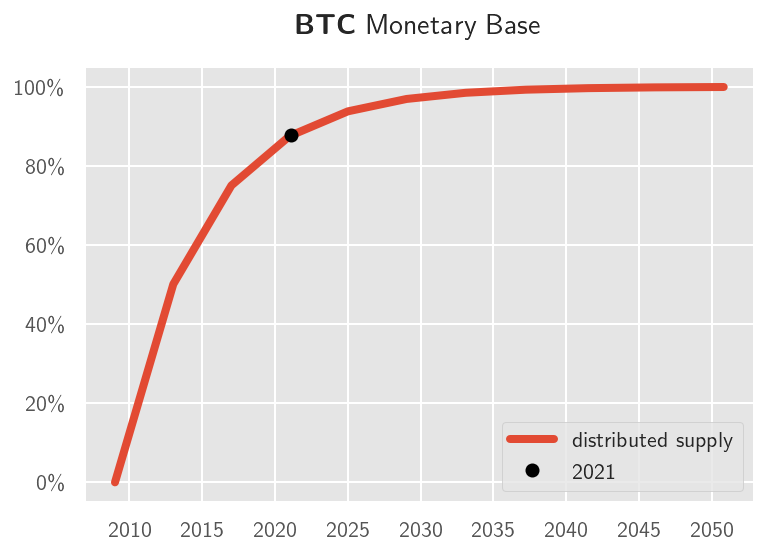

In [24]:
cmb.plot_supply_curve(
    supply,
    'BTC',
);

## Smoothing out the curve

The first and most obvious improvement we can make is to smooth out the curve by replacing periodic halvenings with an exponential decay function. We'll set the half life to 210,000 blocks (~4 years) to match the original curve.

In [25]:
def btc_block_supply_curve_smooth():
    out = [
        # Block num,
        # Total supply,
    ]
    half_life_blocks = 210_000
    tot_supply = 21_000_000
#     initial_reward = 50
    btc_lambda = math.log(2)/half_life_blocks
    y = 0
    block = 0
    while block < 2_200_000:
        block += 1
        y = tot_supply * (1 - (math.exp(-1 * btc_lambda * block)))
        out.append([block, y])

    return out

In [26]:
block_supply = btc_block_supply_curve_smooth()

supply = cmb.datetime_supply_curve(
    start_date=start_date,
    block_time=block_time,
    block_supply=block_supply,
)

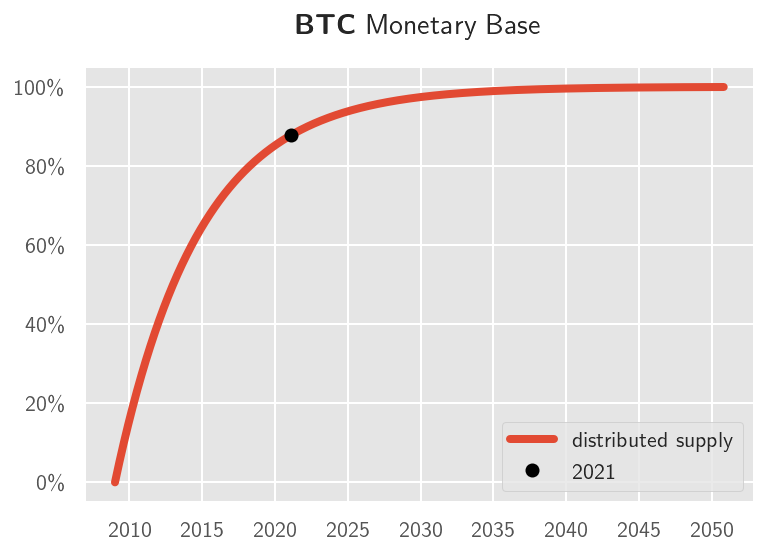

In [27]:
cmb.plot_supply_curve(
    supply,
    'BTC',
);

## Changing the shape of the curve

## Splitting issuance in two

## Baseline vs. simple issuance

## Balancing the two: introducing gamma

## Effective network time: introducing theta

## Supply Curve Calculation

### Some constants

In [4]:
COIN_SYMBOL = 'SMH'
LAYER_TIME = 5 # in minutes
LAYERS_PER_YEAR = 365.25 * 24 * 60 / LAYER_TIME
PREMINE_AMOUNT = 1_500_000

"""
`year` is zero-indexed
"""
def yearly_issuance(plan, year):
    ## PLAN 1
    # Aviv's first proposal: decreasing issuance each year, first ten years only
    if plan == 1:
        if year >= 10:
            return 0
        slots = sum(x for x in range(1, 11))
        per_slot = 4_500_000 / slots
        return per_slot * (10 - year)

    ## PLAN 2
    # Aviv's second proposal: decreasing issuance each year for first ten years,
    # then minor issuance each year for the next twenty years
    elif plan == 2:
        if year >= 30:
            return 0
        # first ten years, linear issuance to 4M
        elif year < 10:
            slots = sum(x for x in range(1, 11))
            per_slot = 4_000_000 / slots
            return per_slot * (10 - year)
        # 25k per year, next 20 years
        elif year < 30:
            return 25_000;
        
    ## PLAN 3
    # Constant issuance, target 6M total issuance in 120 years
    elif plan == 3:
        per_year = (6_000_000 - PREMINE_AMOUNT)/120
        return per_year
    


In [5]:
# Total issuance plan 1
sum(yearly_issuance(1, x) for x in range(10))

4500000.0

In [6]:
# Total issuance plan 2
sum(yearly_issuance(2, x) for x in range(30))

4500000.0

In [7]:
LAYERS_PER_YEAR

105192.0

In [8]:
def smh_layer_supply_curve(
    num_layers,
    output_granularity=10_000,
    ):
    out = [
        # Layer num,
        # Total supply - Plan1,
        # Total supply - Plan2,
    ]
    
    y_1 = y_2 = y_3 = PREMINE_AMOUNT
    layer_reward_plan1 = layer_reward_plan2 = 0
    
    # Plan 3 needs no adjustment as it's constant issuance
    year_issuance_plan3 = yearly_issuance(3, 0)
    layer_reward_plan3 = year_issuance_plan3/LAYERS_PER_YEAR

    for layer in tqdm(range(1, num_layers+1)):
        # Adjust layer reward once per year
        if (layer-1) % math.floor(LAYERS_PER_YEAR) == 0:
            current_year = math.floor((layer-1)/LAYERS_PER_YEAR) # 0-indexed

            # If there is no scheduled issuance for this year (i.e., we are beyond the end of
            # the schedule), then set issuance to zero
            year_issuance_plan1 = year_issuance_plan2 = 0
            
            ## PLAN 1: 10-year issuance model
            
            year_issuance_plan1 = yearly_issuance(1, current_year)
            layer_reward_plan1 = year_issuance_plan1/LAYERS_PER_YEAR
            #print(f"Adjust plan1 layer reward for year {current_year} (total issuance {year_issuance_plan1}) to {layer_reward_plan1}")
            
            ## PLAN 2: 30-year issuance model

            year_issuance_plan2 = yearly_issuance(2, current_year)
            layer_reward_plan2 = year_issuance_plan2/LAYERS_PER_YEAR
            #print(f"Adjust plan2 layer reward for year {current_year} (total issuance {year_issuance_plan2}) to {layer_reward_plan2}")
            
        y_1 += layer_reward_plan1
        y_2 += layer_reward_plan2
        y_3 += layer_reward_plan3
        
        if (layer-1) % output_granularity == 0:
            out.append([layer, y_1, y_2, y_3])

    return out

In [9]:
def datetime_smh_supply_curve(
    start_date,
    layer_time,
    layer_supply,
    output_granularity=10_000,
    ):
    df = pd.DataFrame(
        layer_supply, columns=['layer', 'plan1', 'plan2', 'plan3']
    )
    df['plan1_pct'] = (
        df['plan1'] / df['plan1'].values[-1]
        * 100
    )
    df['plan2_pct'] = (
        df['plan2'] / df['plan2'].values[-1]
        * 100
    )
    df['plan3_pct'] = (
        df['plan3'] / df['plan3'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=layer_time * output_granularity,
        periods=len(df)
    )
    return df

In [10]:
def plot_smh_supply_curve(
    supply,
    coin_name='SMH',
    plot_pct=False,
    max_size=10_000,
    out_name='',
    ):
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # Plan1
    if plot_pct:
        values = supply.plan1_pct.values[::step_size]
    else:
        values = supply.plan1.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='plan1',
    )
    
    # Plan2
    if plot_pct:
        values = supply.plan2_pct.values[::step_size]
    else:
        values = supply.plan2.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt='-',
        lw=4,
        label='plan2',
        color='orange',
    )
    
    # Plan3
    if plot_pct:
        values = supply.plan3_pct.values[::step_size]
    else:
        values = supply.plan3.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt='.',
        lw=4,
        label='plan3',
        color='green',
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    plt.legend()
    
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
    if not out_name:
        out_name = coin_name
    plt.savefig(
        f'../charts/{out_name}.png',
        bbox_inches='tight',
        dpi=300
    )
    return plt

In [11]:
start_date = datetime.date(2021, 7, 1)
end_date = datetime.date(2140, 10, 7)
layer_time = datetime.timedelta(minutes=LAYER_TIME)

num_layers = int(
    ((end_date - start_date).days * 24 * 3600)
    / layer_time.seconds
)

layer_supply = smh_layer_supply_curve(
    num_layers=num_layers,
)

supply = datetime_smh_supply_curve(
    start_date=start_date,
    layer_time=layer_time,
    layer_supply=layer_supply,
)

  0%|          | 0/12545856 [00:00<?, ?it/s]

In [12]:
display(supply.head())
display(supply.tail())

,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
0,1,1.500008e+06,1.500007e+06,1.500000e+06,25.000130,25.000115,25.123962,2021-07-01 00:00:00
1,10001,1.577788e+06,1.569145e+06,1.503565e+06,26.296460,26.152409,25.183672,2021-08-04 17:20:00
2,20001,1.655567e+06,1.638282e+06,1.507130e+06,27.592791,27.304703,25.243381,2021-09-08 10:40:00
3,30001,1.733347e+06,1.707420e+06,1.510695e+06,28.889122,28.456998,25.303091,2021-10-13 04:00:00
4,40001,1.811127e+06,1.776557e+06,1.514260e+06,30.185453,29.609292,25.362801,2021-11-16 21:20:00


,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
1250,12500001,6.000000e+06,6.000000e+06,5.956138e+06,100.0,100.0,99.761161,2140-04-30 18:40:00
1251,12510001,6.000000e+06,6.000000e+06,5.959703e+06,100.0,100.0,99.820871,2140-06-04 12:00:00
1252,12520001,6.000000e+06,6.000000e+06,5.963268e+06,100.0,100.0,99.880580,2140-07-09 05:20:00
1253,12530001,6.000000e+06,6.000000e+06,5.966832e+06,100.0,100.0,99.940290,2140-08-12 22:40:00
1254,12540001,6.000000e+06,6.000000e+06,5.970397e+06,100.0,100.0,100.000000,2140-09-16 16:00:00


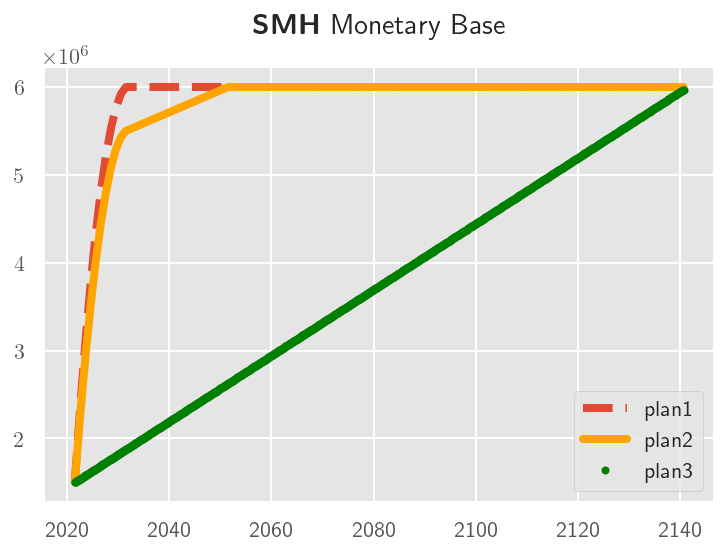

In [13]:
plot_smh_supply_curve(supply);

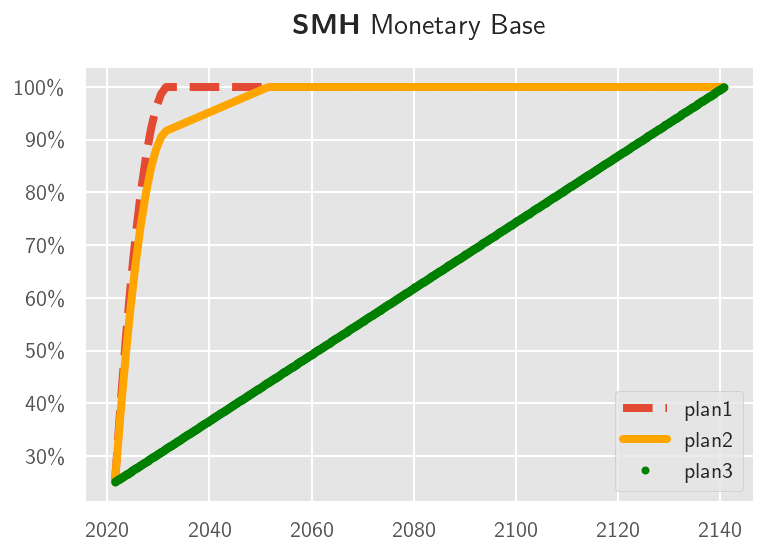

In [14]:
plot_smh_supply_curve(supply, plot_pct=True, out_name='SMH_pct');

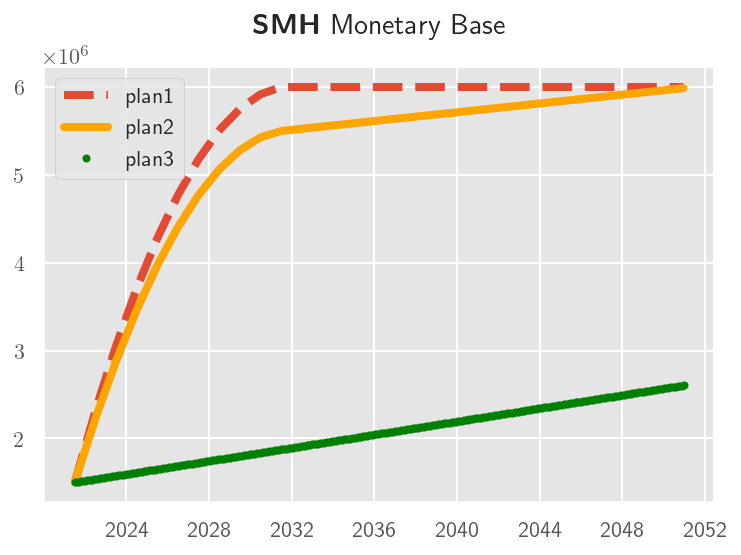

In [15]:
mask = supply.date < datetime.datetime(2051, 1, 1)
plot_smh_supply_curve(supply[mask], out_name='SMH_zoom');

## Standardize Time Series

In [16]:
weekly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='weekly')

display(weekly_supply.head())
display(weekly_supply.tail())

Wrote 1255 lines to file ../output-data/SMH_weekly.csv


,coin,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
0,SMH,1,1.500008e+06,1.500007e+06,1.500000e+06,25.000130,25.000115,25.123962,2021-07-01
1,SMH,10001,1.577788e+06,1.569145e+06,1.503565e+06,26.296460,26.152409,25.183672,2021-08-01
2,SMH,20001,1.655567e+06,1.638282e+06,1.507130e+06,27.592791,27.304703,25.243381,2021-09-01
3,SMH,30001,1.733347e+06,1.707420e+06,1.510695e+06,28.889122,28.456998,25.303091,2021-10-01
4,SMH,40001,1.811127e+06,1.776557e+06,1.514260e+06,30.185453,29.609292,25.362801,2021-11-01


,coin,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
1250,SMH,12500001,6.000000e+06,6.000000e+06,5.956138e+06,100.0,100.0,99.761161,2140-04-01
1251,SMH,12510001,6.000000e+06,6.000000e+06,5.959703e+06,100.0,100.0,99.820871,2140-06-01
1252,SMH,12520001,6.000000e+06,6.000000e+06,5.963268e+06,100.0,100.0,99.880580,2140-07-01
1253,SMH,12530001,6.000000e+06,6.000000e+06,5.966832e+06,100.0,100.0,99.940290,2140-08-01
1254,SMH,12540001,6.000000e+06,6.000000e+06,5.970397e+06,100.0,100.0,100.000000,2140-09-01


In [17]:
monthly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='monthly')

display(monthly_supply.head())
display(monthly_supply.tail())

Wrote 1255 lines to file ../output-data/SMH_monthly.csv


,coin,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
0,SMH,1,1.500008e+06,1.500007e+06,1.500000e+06,25.000130,25.000115,25.123962,2021-07-01
1,SMH,10001,1.577788e+06,1.569145e+06,1.503565e+06,26.296460,26.152409,25.183672,2021-08-01
2,SMH,20001,1.655567e+06,1.638282e+06,1.507130e+06,27.592791,27.304703,25.243381,2021-09-01
3,SMH,30001,1.733347e+06,1.707420e+06,1.510695e+06,28.889122,28.456998,25.303091,2021-10-01
4,SMH,40001,1.811127e+06,1.776557e+06,1.514260e+06,30.185453,29.609292,25.362801,2021-11-01


,coin,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
1250,SMH,12500001,6.000000e+06,6.000000e+06,5.956138e+06,100.0,100.0,99.761161,2140-04-01
1251,SMH,12510001,6.000000e+06,6.000000e+06,5.959703e+06,100.0,100.0,99.820871,2140-06-01
1252,SMH,12520001,6.000000e+06,6.000000e+06,5.963268e+06,100.0,100.0,99.880580,2140-07-01
1253,SMH,12530001,6.000000e+06,6.000000e+06,5.966832e+06,100.0,100.0,99.940290,2140-08-01
1254,SMH,12540001,6.000000e+06,6.000000e+06,5.970397e+06,100.0,100.0,100.000000,2140-09-01


In [18]:
yearly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='yearly')

display(yearly_supply.head())
display(yearly_supply.tail())

Wrote 120 lines to file ../output-data/SMH_yearly.csv


,coin,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
0,SMH,1,1.500008e+06,1.500007e+06,1.500000e+06,25.000130,25.000115,25.123962,2021-07-01
1,SMH,60001,1.966687e+06,1.914833e+06,1.521390e+06,32.778115,31.913880,25.482220,2022-01-01
2,SMH,160001,2.701855e+06,2.568316e+06,1.557039e+06,45.030917,42.805260,26.079318,2023-01-01
3,SMH,270001,3.425506e+06,3.211561e+06,1.596253e+06,57.091759,53.526008,26.736125,2024-01-01
4,SMH,370001,4.005413e+06,3.727034e+06,1.631902e+06,66.756878,62.117225,27.333223,2025-01-01


,coin,layer,plan1,plan2,plan3,plan1_pct,plan2_pct,plan3_pct,date
115,SMH,12050001,6.000000e+06,6.000000e+06,5.795717e+06,100.0,100.0,97.074222,2136-01-01
116,SMH,12150001,6.000000e+06,6.000000e+06,5.831366e+06,100.0,100.0,97.671319,2137-01-01
117,SMH,12260001,6.000000e+06,6.000000e+06,5.870580e+06,100.0,100.0,98.328127,2138-01-01
118,SMH,12370001,6.000000e+06,6.000000e+06,5.909794e+06,100.0,100.0,98.984934,2139-02-01
119,SMH,12470001,6.000000e+06,6.000000e+06,5.945443e+06,100.0,100.0,99.582032,2140-01-01
